## Important
Before running the script, you should download the data from [kaggle website](https://www.kaggle.com/nih-chest-xrays/data). 

In [1]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
from skimage import io
import random
from scipy import stats

sns.set_style('darkgrid')

In [3]:
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

Image Index Finding Labels  Follow-up #  Patient ID Patient Age  \
993   00005202_000.png     No Finding            0        5202        056Y   
2580  00012935_009.png     No Finding            9       12935        055Y   
4369  00021582_010.png     No Finding           10       21582        072Y   

     Patient Gender View Position  OriginalImageWidth  OriginalImageHeight  \
993               F            AP                2500                 2048   
2580              M            PA                2798                 2991   
4369              F            PA                2614                 2991   

      OriginalImagePixelSpacing_x  OriginalImagePixelSpacing_y  
993                         0.171                        0.171  
2580                        0.143                        0.143  
4369                        0.143                        0.143

In [4]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [5]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 481.9+ KB


## One hot encoding labels
This step creates columns to store each label in binary form (i.e. "0" or "1").      
Additionally, since there are some outliers in the 'Patient Age' column, I removed the rows correlated with ages that are greater than 100 years old except for the one positive pneumonia case (`new_xray_df`).

However, for the sake of demographic inference, I removed all rows that consists of age greater than 100 (cleaned dataframe `xray_df`).

In [6]:
# One hot encoding labels
labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if len(x)>0]
for c_label in labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0) 
        
print(all_xray_df[labels].sum().sort_values(ascending=False))

No Finding            60361.0
Infiltration          19894.0
Effusion              13317.0
Atelectasis           11559.0
Nodule                 6331.0
Mass                   5782.0
Pneumothorax           5302.0
Consolidation          4667.0
Pleural_Thickening     3385.0
Cardiomegaly           2776.0
Emphysema              2516.0
Edema                  2303.0
Fibrosis               1686.0
Pneumonia              1431.0
Hernia                  227.0
dtype: float64


In [7]:
len(all_xray_df), len(all_xray_df['Patient ID'].unique())

(112120, 30805)

## Demonstrate demographics of the patients
In this section, we visualize the distribution of 
* Patient Age
* Patient Gender
* View Position

In [8]:
print(f'The dataset consists of images from {len(all_xray_df["Patient ID"].unique())} unique patients.')

The dataset consists of images from 30805 unique patients.


In [9]:
## EDA
# Present patients' demographic data, where each each image entry is treated as an individual. 
def demographic(df, key, bins=3, savefig=False):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.hist(df[key], bins=bins)
    ax.set(xlabel=f'{key}', ylabel='Number of occurrences')
    if savefig==True:
        plt.savefig(f'{key}_distribution.png')

### Patient Age 
In the dataset, we found 16 entries with an age older than 100 years old, and among them, one patient is Pneumonia positive.      
After removing these data points (dataframe `xray_df`), the patient age range from 1-year-old to 95-year-old. The patient age roughly follows a normal distribution.

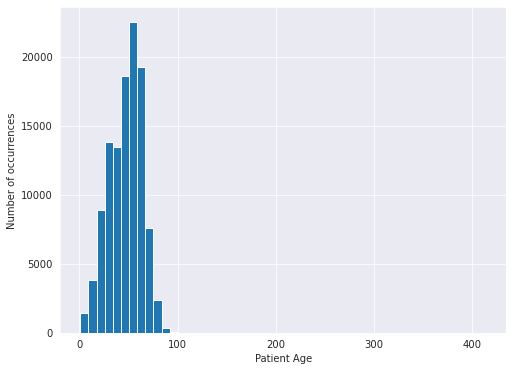

In [10]:
demographic(all_xray_df, 'Patient Age', bins=50)

In [11]:
# Remove patient age outliers
over100 = all_xray_df[(all_xray_df['Patient Age'] > 100)]
print(f'In the dataset, there are {len(over100)} patients with age older than 100 years old, and among them {len(over100[over100.Pneumonia==1])} is(are) diagnosed with Pneumonia.')
xray_df = all_xray_df[(all_xray_df['Patient Age'] <= 100)] 
over100

In the dataset, there are 16 patients with age older than 100 years old, and among them 1 is(are) diagnosed with Pneumonia.


Image Index           Finding Labels  Follow-up #  Patient ID  \
20852   00005567_000.png       Effusion|Pneumonia            0        5567   
46965   00011973_002.png                    Edema            2       11973   
48284   00012238_010.png               No Finding           10       12238   
55742   00013950_000.png               No Finding            0       13950   
58650   00014520_026.png        Infiltration|Mass           26       14520   
62929   00015558_000.png               No Finding            0       15558   
74884   00018366_044.png             Pneumothorax           44       18366   
78795   00019346_000.png             Infiltration            0       19346   
84810   00020900_002.png               No Finding            2       20900   
85404   00021047_002.png  Mass|Pleural_Thickening            2       21047   
86264   00021275_003.png               No Finding            3       21275   
91369   00022811_000.png               No Finding            0       22811   
95794   00025206_000.png        Infiltration|Mass            0       25206   
98495   00026028_001.png              Atelectasis            1       26028   
101194  00026871_000.png               No Finding            0       26871   
104590  00027989_000.png               No Finding            0       27989   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
20852           412              M            AP                 3056   
46965           414              M            AP                 3056   
48284           148              M            PA                 2992   
55742           148              M            PA                 2964   
58650           150              M            PA                 2992   
62929           149              M            PA                 2992   
74884           152              F            PA                 2302   
78795           151              F            PA                 2678   
84810           411              M            AP                 3056   
85404           412              M            AP                 3056   
86264           413              F            AP                 3056   
91369           412              M            PA                 3056   
95794           153              M            PA                 2992   
98495           154              M            PA                 2992   
101194          155              F            PA                 2992   
104590          155              M            PA                 2992   

        Height]  OriginalImagePixelSpacing[x  ...  Emphysema  Fibrosis  \
20852      2544                        0.139  ...        0.0       0.0   
46965      2544                        0.139  ...        0.0       0.0   
48284      2991                        0.143  ...        0.0       0.0   
55742      2939                        0.143  ...        0.0       0.0   
58650      2991                        0.143  ...        0.0       0.0   
62929      2991                        0.143  ...        0.0       0.0   
74884      2991                        0.143  ...        0.0       0.0   
78795      2774                        0.143  ...        0.0       0.0   
84810      2544                        0.139  ...        0.0       0.0   
85404      2544                        0.139  ...        0.0       0.0   
86264      2544                        0.139  ...        0.0       0.0   
91369      2544                        0.139  ...        0.0       0.0   
95794      2991                        0.143  ...        0.0       0.0   
98495      2991                        0.143  ...        0.0       0.0   
101194     2991                        0.143  ...        0.0       0.0   
104590     2991                        0.143  ...        0.0       0.0   

        Hernia  Infiltration  Mass  No Finding  Nodule  Pleural_Thickening  \
20852      0.0           0.0   0.0         0.0     0.0                 0.0   
46965      0.0           0.0 

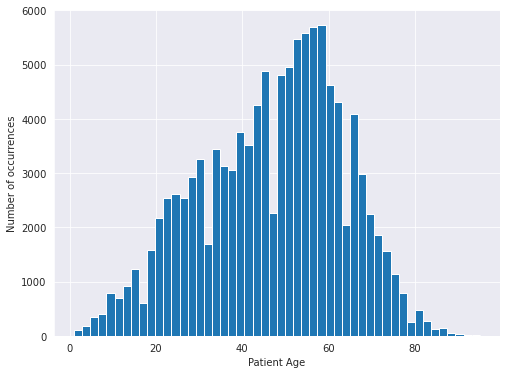

In [12]:
demographic(xray_df, 'Patient Age', bins=50)

After removing the outliers with age above 100 years old, the patient age ranges from 1-year-old to 95-year-old.

In [13]:
xray_df['Patient Age'].describe()

count    112104.000000
mean         46.872574
std          16.598152
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max          95.000000
Name: Patient Age, dtype: float64

### Patient Gender 
The dataset consists of 56.5% male and 43.5% female.

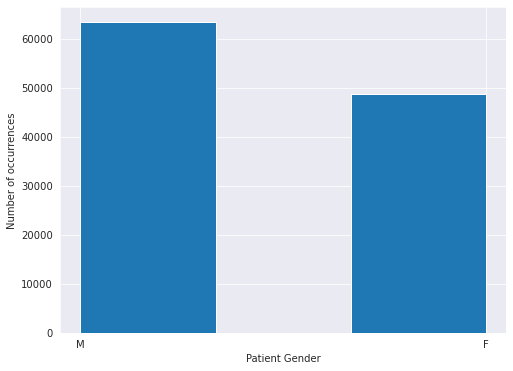

In [14]:
demographic(all_xray_df, 'Patient Gender')

In [15]:
male = all_xray_df[all_xray_df['Patient Gender']=='M']
female = all_xray_df[all_xray_df['Patient Gender']=='F']
print('Male: {:.1%} \nFemale: {:.1%}'.format(len(male)/len(all_xray_df), len(female)/len(all_xray_df)))
all_xray_df['Patient Gender'].value_counts()

Male: 56.5% 
Female: 43.5%


M    63340
F    48780
Name: Patient Gender, dtype: int64

### View Position
There are 60.03% PA view position, and 39.97% AP view position. 

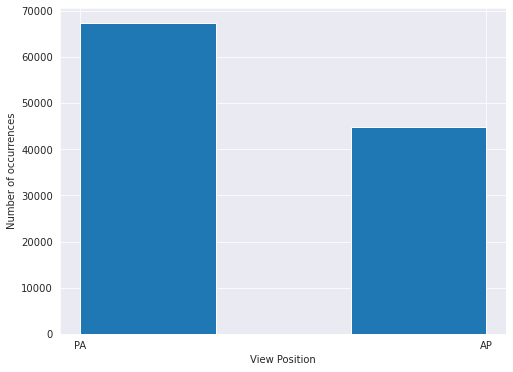

In [16]:
demographic(all_xray_df, 'View Position')

In [17]:
PA = all_xray_df[all_xray_df['View Position']=='PA']
AP = all_xray_df[all_xray_df['View Position']=='AP']
print('PA: {:.2%} \nAP: {:.2%}'.format(len(PA)/len(all_xray_df), len(AP)/len(all_xray_df)))
all_xray_df['View Position'].value_counts()

PA: 60.03% 
AP: 39.97%


PA    67310
AP    44810
Name: View Position, dtype: int64

## Distribution of diseases in the dataset 
From the distribution we can conclude that:
* The most common label in the dataset is 'No Finding' (53.8% of the data).
* The prevalence of pneumonia in the dataset is 1.28% (1431 cases in total, with 1 patient's age above 100-year-old). 
* The most common co-occurence with pneumonia is infiltration which is the second most common label in the dataset.
* There are 322 pnemonia-only cases.

In [18]:
# Percentage of cases of each label 
percent = (all_xray_df[labels].sum()/len(all_xray_df))
percent.sort_values(ascending=False)
print('The prevalence of Pneumonia in the dataset is {:.2%}.'.format(len(all_xray_df[all_xray_df.Pneumonia==1])/len(all_xray_df)))

The prevalence of Pneumonia in the dataset is 1.28%.


### Number of follow-ups for unique patients

In [19]:
follow_ups = []
for ind in all_xray_df['Patient ID'].unique():
    follow_ups.append(all_xray_df[all_xray_df['Patient ID']==ind]['Follow-up #'].max())

In [20]:
# follow_ups.count(max(follow_ups)), max(follow_ups)
all_xray_df[all_xray_df['Follow-up #']==all_xray_df['Follow-up #'].max()]

Image Index         Finding Labels  Follow-up #  Patient ID  \
38264  00010007_183.png  Effusion|Infiltration          183       10007   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
38264           59              M            AP                 2500     2048   

       OriginalImagePixelSpacing[x  ...  Emphysema  Fibrosis  Hernia  \
38264                        0.168  ...        0.0       0.0     0.0   

       Infiltration  Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  \
38264           1.0   0.0         0.0     0.0                 0.0        0.0   

       Pneumothorax  
38264           0.0  

[1 rows x 27 columns]

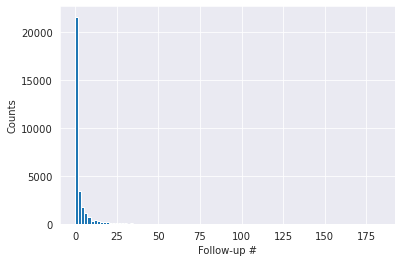

Most patients have 0 follow-up(s), and the maxium number of follow-ups is 183.


In [21]:
f, ax = plt.subplots(figsize=(6,4))
ax.hist(follow_ups, bins=100)
ax.set(xlabel='Follow-up #', ylabel='Counts')
plt.show()
print('Most patients have {} follow-up(s), and the maxium number of follow-ups is {}.'.format(all_xray_df['Follow-up #'].value_counts().argmax(),all_xray_df['Follow-up #'].max()))

### The ratio of single label vs. multiple labels among patients

In [22]:
df = pd.DataFrame(columns = ['Labels', 'Single', 'Multiple'])
pathology = labels.copy()
pathology.remove('No Finding')

In [23]:
for i, l in enumerate(pathology):
    single = (all_xray_df['Finding Labels']==l).sum()
    multiple = len(all_xray_df[all_xray_df[l]==1])
#     for ind in (all_xray_df[all_xray_df[l]==1]['Finding Labels'].map(lambda x: x.split('|')).tolist()):
#         if len(ind)>1:
#             multiple +=1
    df.loc[i] = [l, single, multiple]
df = df.sort_values('Multiple', ascending=False)

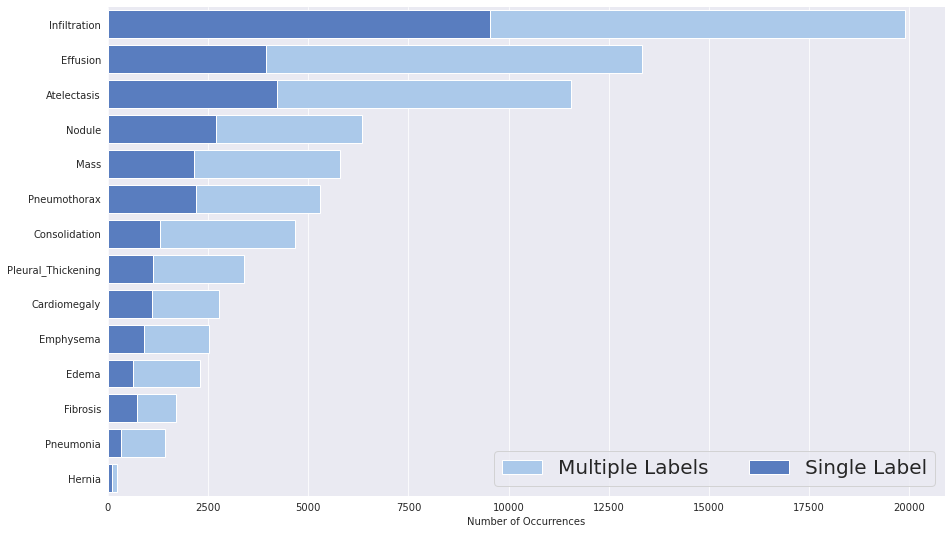

In [24]:
f, ax = plt.subplots(figsize=(15,9))
sns.set_color_codes("pastel")
g = sns.barplot(x="Multiple", y="Labels", data=df, label="Multiple Labels",color='b')
sns.set_color_codes("muted")
g = sns.barplot(x="Single", y="Labels", data=df, label="Single Label",color='b')
ax.legend(ncol=2, loc="lower right", frameon=True, fontsize=20)
ax.set(xlabel="Number of Occurrences", ylabel="")
sns.despine(left=True, bottom=True)

### Imbalanced Dataset
From the distribution of dataset, we can see that there are only a small amount of pneumonia positive images in the dataset. This leads to a significant larger amount of negative images than positive ones. I compensated for this imbalancing pneumonia positive data by balancing the training dataset such that the model sees equal amount of positive and negative images during training.      

Additionally, since most pneumonia positive images have multiple labels, an alternative approach is to mark the most common comorodity, infiltration, as pneumonia positive. This way, we may reduce false negative despite a potential higher false positive. 

### The distribution of number of pathologies per patient

In [25]:
labels_per_patient = all_xray_df.groupby(['Patient ID'])[pathology].sum()
labels_per_patient['total labels'] = labels_per_patient.astype('bool').sum(axis=1)
labels_per_patient.sample(5)

Atelectasis  Cardiomegaly  Consolidation  Edema  Effusion  \
Patient ID                                                              
25005               0.0           1.0            0.0    0.0       0.0   
25889               0.0           0.0            0.0    0.0       0.0   
12098               0.0           0.0            0.0    0.0       0.0   
21207               0.0           0.0            0.0    0.0       0.0   
28536               0.0           0.0            0.0    0.0       0.0   

            Emphysema  Fibrosis  Hernia  Infiltration  Mass  Nodule  \
Patient ID                                                            
25005             0.0       0.0     0.0           0.0   0.0     0.0   
25889             0.0       0.0     0.0           0.0   0.0     0.0   
12098             0.0       0.0     0.0           0.0   0.0     0.0   
21207             0.0       0.0     0.0           1.0   0.0     1.0   
28536             0.0       0.0     0.0           0.0   0.0     0.0   

            Pleural_Thickening  Pneumonia  Pneumothorax  total labels  
Patient ID                                                             
25005                      0.0        0.0           0.0             1  
25889                      0.0        0.0           0.0             0  
12098                      0.0        0.0           0.0             0  
21207                      0.0        0.0           0.0             2  
28536                      0.0        0.0           0.0             0

Text(0.5, 1.0, 'Distribution of Number of Labels Per Patient')

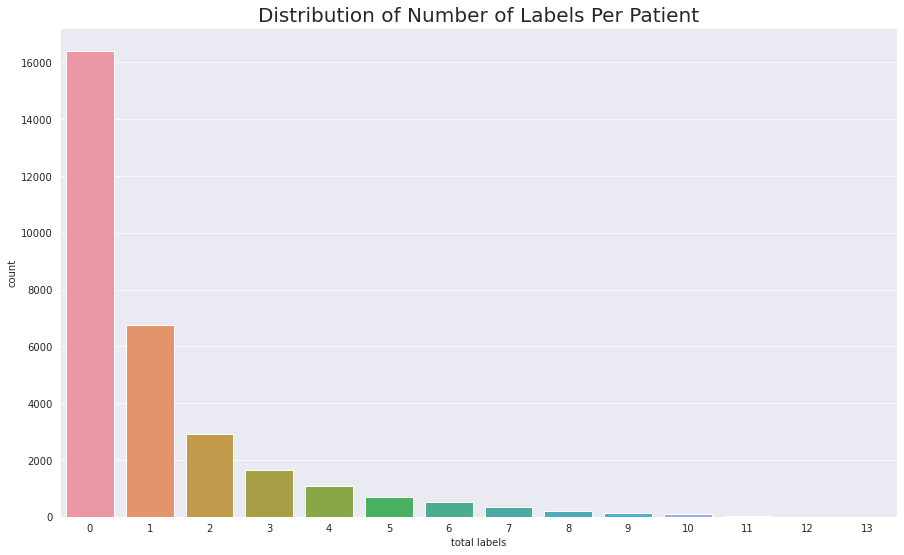

In [26]:
f, ax = plt.subplots(figsize=(15,9))
g = sns.countplot(x='total labels', data=labels_per_patient)
ax.set_title('Distribution of Number of Labels Per Patient', fontsize=20)

### The top 20 comorbidities with pneumonia.

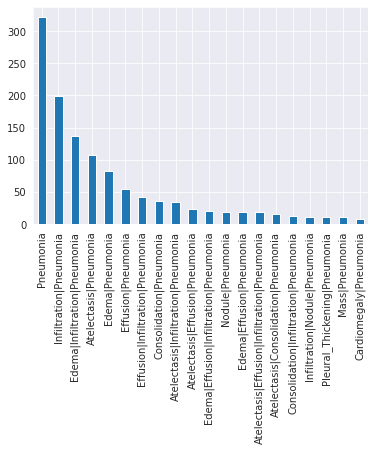

In [27]:
all_xray_df[all_xray_df['Pneumonia']==1]['Finding Labels'].value_counts()[0:20].plot(kind='bar')


### Co-occurence of diseases (pneumonia positive).

[Text(0, 0.5, 'counts')]

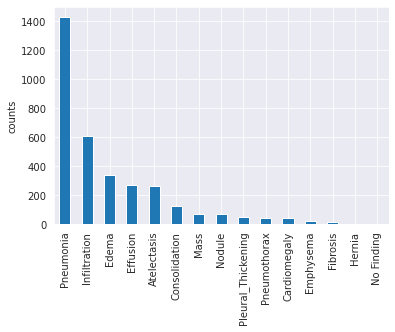

In [28]:
ax = all_xray_df[all_xray_df['Pneumonia']==1][labels].sum().sort_values(ascending=False).plot(kind='bar')
ax.set(ylabel='counts')

In [29]:
all_xray_df[all_xray_df['Pneumonia']==1][labels].sum().sort_values(ascending=False)

Pneumonia             1431.0
Infiltration           605.0
Edema                  340.0
Effusion               269.0
Atelectasis            262.0
Consolidation          123.0
Mass                    71.0
Nodule                  70.0
Pleural_Thickening      48.0
Pneumothorax            41.0
Cardiomegaly            41.0
Emphysema               23.0
Fibrosis                11.0
Hernia                   3.0
No Finding               0.0
dtype: float64

In [30]:
print('There are {} patients who are diagnosed with Pneumonia only.'.format(len(all_xray_df.loc[all_xray_df['Finding Labels']=='Pneumonia'])))

There are 322 patients who are diagnosed with Pneumonia only.


### Number of records associated with patients who are Pneumonia positive. 

In [31]:
data = all_xray_df[all_xray_df['Pneumonia']==1]
data['record_per_patient'] = data['Patient ID'].map(
    lambda counts: data['Pneumonia'].groupby(data['Patient ID']).sum()[counts])
data.sample(5)
np.histogram(data.groupby('Patient ID')['Pneumonia'].sum())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(array([785, 130,  43,  23,  13,   8,   2,   1,   1,   2]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]))

[Text(0, 0.5, 'counts'), Text(0.5, 0, 'number of records per patient')]

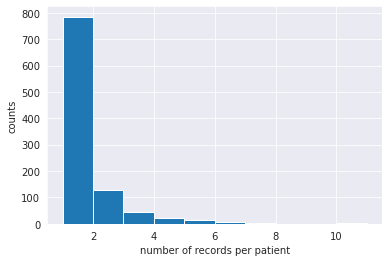

In [32]:
ax = data.groupby('Patient ID')['Pneumonia'].sum().hist(bins=10)
ax.set(ylabel='counts', xlabel='number of records per patient')

### The number of non-pneumonia cases
The label with the highest occurrences is "No Finding", and the most common pathology among non-pneumonia patients in the dataset is *Infiltration*.

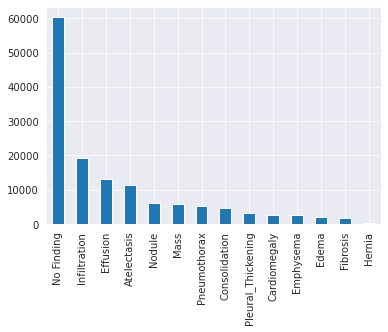

In [33]:
# Display the number of non-pneumonia cases
np_labels = [x for x in labels if (x!= 'Pneumonia')]
all_xray_df[all_xray_df['Pneumonia']==0][np_labels].sum().sort_values(ascending=False).plot(kind='bar')

## Demographics of Pneumonia positive cases

### Patient Age
The one outlier is removed from display. 

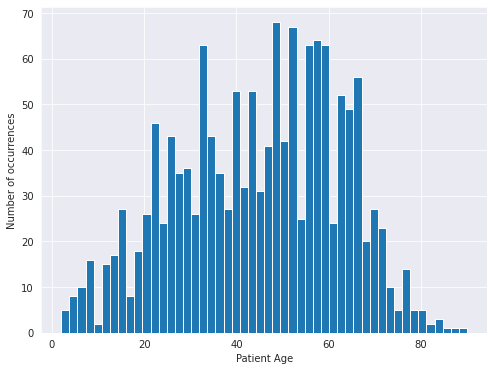

In [34]:
demographic(xray_df[xray_df.Pneumonia==1], 'Patient Age', bins=50)

### Patient Gender

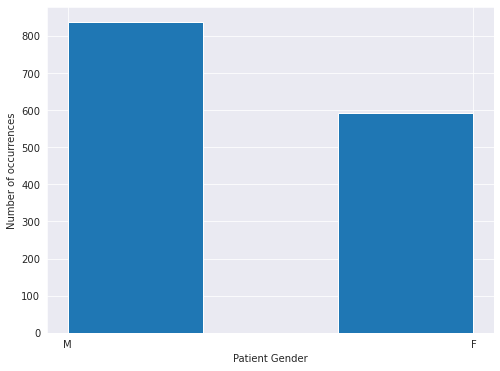

In [35]:
demographic(xray_df[xray_df.Pneumonia==1], 'Patient Gender')

### View position

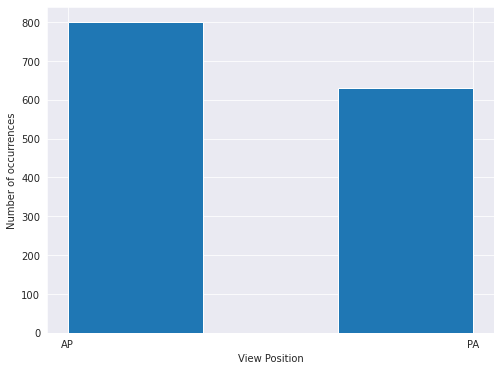

In [36]:
demographic(xray_df[xray_df.Pneumonia==1], 'View Position')

## Pixel-level assessment

In [37]:
slabels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
slabels = [x for x in slabels if len(x)>0]
for c_label in slabels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)  
print(sample_df[slabels].sum().sort_values(ascending=False))

No Finding            3044.0
Infiltration           967.0
Effusion               644.0
Atelectasis            508.0
Nodule                 313.0
Mass                   284.0
Pneumothorax           271.0
Consolidation          226.0
Pleural_Thickening     176.0
Cardiomegaly           141.0
Emphysema              127.0
Edema                  118.0
Fibrosis                84.0
Pneumonia               62.0
Hernia                  13.0
dtype: float64


In [38]:
imgs = glob("/data/images*/images/*.png") # glob all images from the data. 
imgs = {img.split('/')[-1]: img for img in imgs}

### Display images in grayscale and corresponding intensity profile

In [39]:
def read_images(df, imgs, *labels, nsample=2):
    fig, axes = plt.subplots(ncols=2*nsample, nrows=len(labels), figsize=(nsample*10, len(labels)*5))
    for i, l in enumerate(labels):
        sample = df.loc[df['Finding Labels']==l].sample(nsample)
        ind = 0
        for j, (index, row) in enumerate(sample.iterrows()):
            orig_img = io.imread(imgs[row['Image Index']])
#             img = (orig_img - np.mean(orig_img))/np.std(orig_img)
            axes[i, ind].imshow(orig_img, cmap='gray') 
            axes[i, ind].set_title(l)
            axes[i, ind+1].hist(orig_img.ravel(), bins=256, color='lightblue')
            axes[i, ind+1].set_title('{} mean: {:.2f}'.format(l, np.mean(orig_img)))
            ind =+2

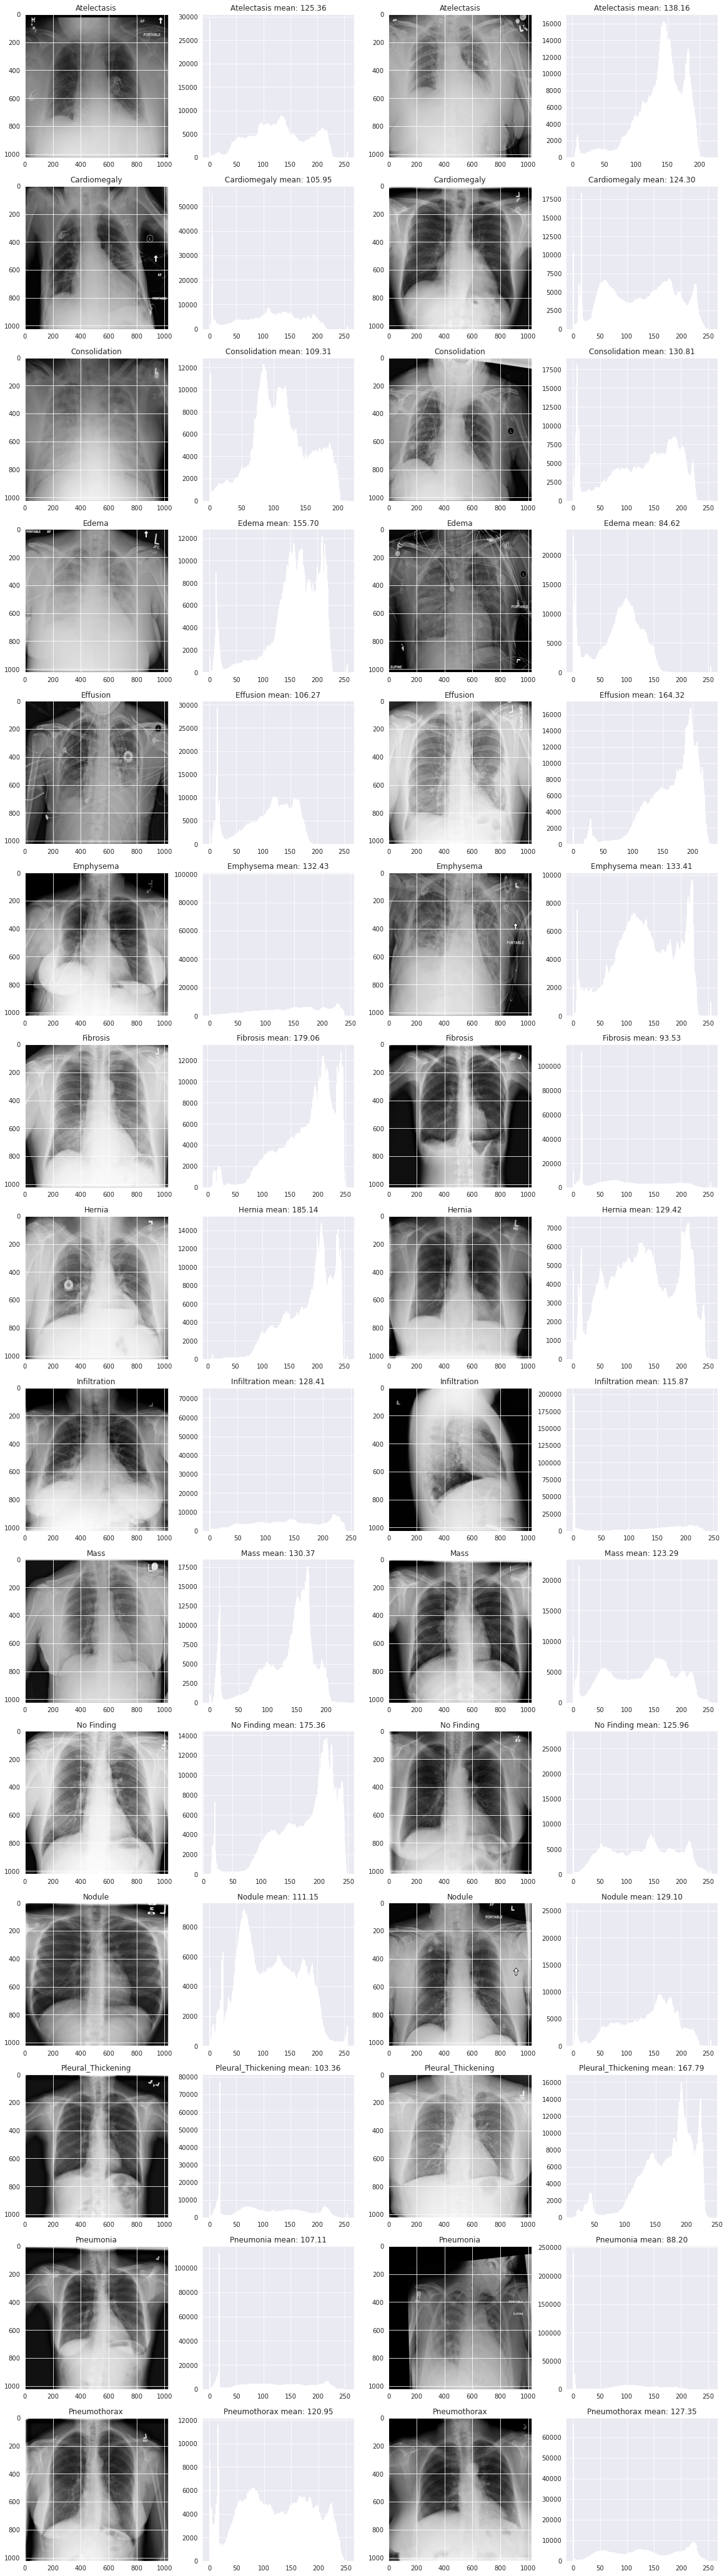

In [40]:
read_images(sample_df, imgs, *slabels)

### Foreground and background removed display

In [41]:
def read_masked_images(df, imgs, *labels, nsample=2, background_threshold=0.1, foreground_threshold=0.75):
    fig, axes = plt.subplots(ncols=3*nsample, nrows=len(labels), figsize=(nsample*15, len(labels)*5))
    for i, l in enumerate(labels):
        sample = df.loc[df['Finding Labels']==l].sample(nsample)
        ind = 0
        for j, (index, row) in enumerate(sample.iterrows()):
            orig_img = io.imread(imgs[row['Image Index']])
            img = (orig_img - np.mean(orig_img))/np.std(orig_img)
            mask = (img > background_threshold) & (img < foreground_threshold)
            axes[i, ind].imshow(img, cmap='gray') 
            axes[i, ind].set_title(l+': Original')
            axes[i, ind+1].imshow(mask.astype(int)*255, cmap='gray') 
            axes[i, ind+1].set_title(l+': Masked')
            axes[i, ind+2].hist(img[mask].ravel(), bins=256, color='lightblue')
            axes[i, ind+2].set_title(l+': Intensity')
            ind =+3

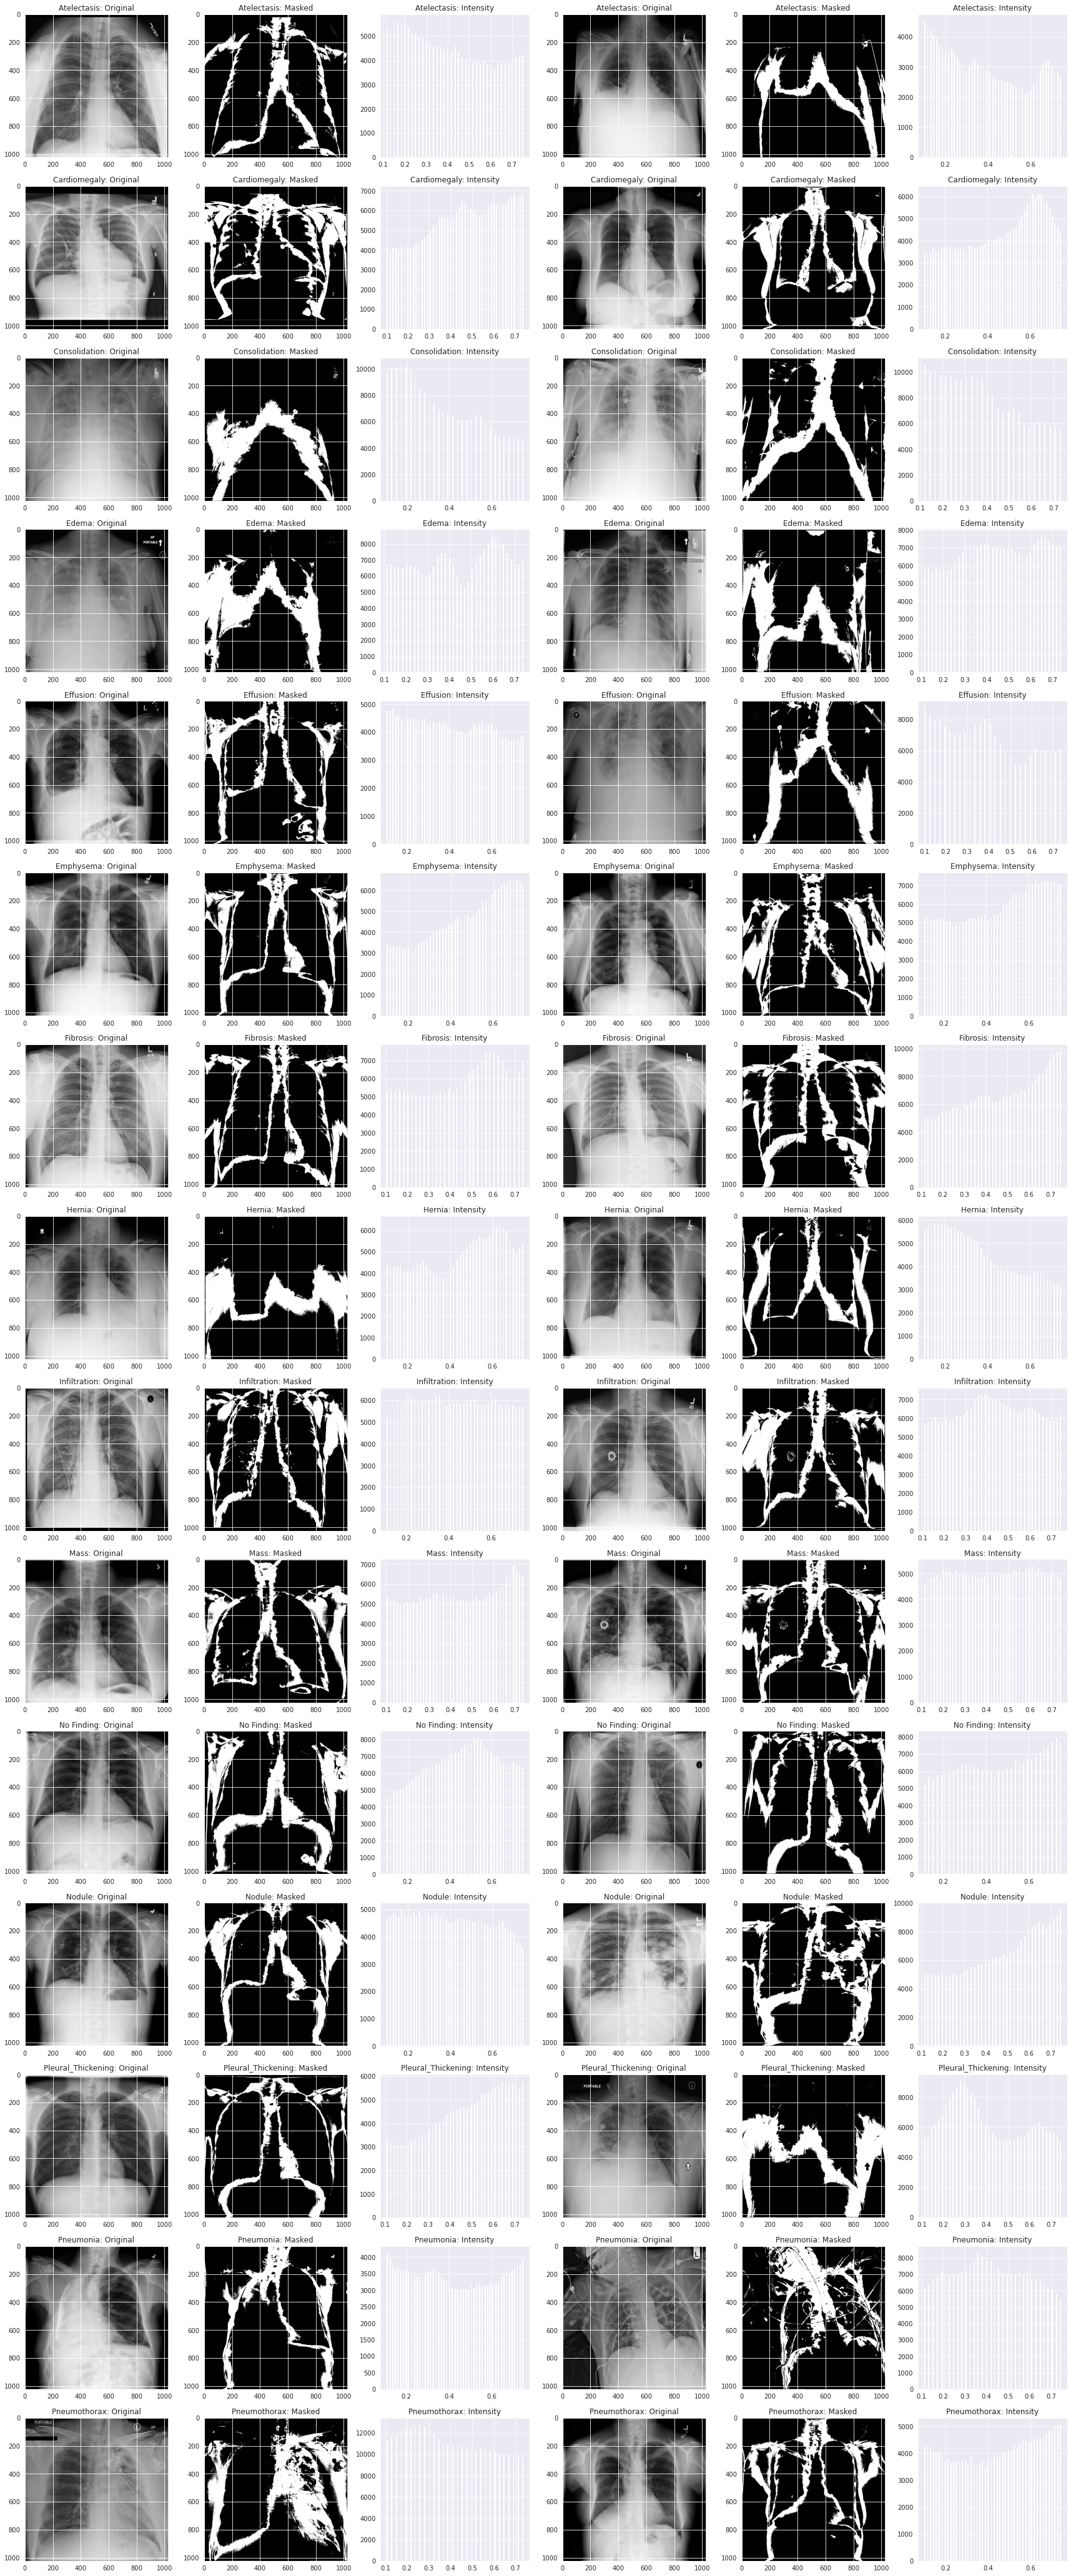

In [42]:
read_masked_images(sample_df, imgs, *slabels)

## Summary of Intensity Profile 


By examing the intensity profile, it is difficult to distinguish one label from the other, especially when the there is too much background getting displayed or when the image is over-exposed. Here, I applied normalization and masking the foreground and background to reduce the noise in the image.    

From the normalized and masked, *Infiltration*, *Effusion*, *Mass*, and *Pleural Thickening* present a similar distribution of intensity (especially the peak of intensity) as observed in Pneumonia. Among these four pathologies, Infiltration and Effusion are among the top comorbidities with Pneumonia, which makes the diagnosis of Pneumonia be more difficult because these pathological features can be mistaken as Pneumonia, and vice versa. 

In [43]:
# def read_intensity(df, imgs, *labels, nsample=1, background_threshold=0.1, foreground_threshold=0.9):
#     fig, axes = plt.subplots(ncols=2*nsample, nrows=len(labels), figsize=(nsample*10, len(labels)*5))
#     for i, l in enumerate(labels):
#         sample = df.loc[df['Finding Labels']==l].sample(nsample)
#         ind = 0
#         for j, (index, row) in enumerate(sample.iterrows()):
#             orig_img = io.imread(imgs[row['Image Index']])
#             img = (orig_img - np.mean(orig_img))/np.std(orig_img)
#             axes[i, ind].hist(orig_img.ravel(), bins=256, color='lightblue') 
#             axes[i, ind].set_title('{} mean: {:.2f}, stedev: {:.2f}'.format(l, np.mean(orig_img),np.std(orig_img)))
#             mask = (img > background_threshold) & (img < foreground_threshold)
#             axes[i, ind+1].hist(img[mask].ravel(), bins=256, color='lightblue')
#             axes[i, ind+1].set_title('mean: {:.2f}, stedev: {:.2f}'.format(np.mean(img[mask]),np.std(img[mask])))
#             ind =+2